In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Overview & Preprocessing**
**Dataset:** Volkswagen Stock Price Data

**Source:** Investing.com

**Date Range:** January 2, 2020 – January 2, 2025

**Features Used:**

*   Price: Closing stock price
*   Open, High, Low: Daily price fluctuations
*   Vol.: Trading volume (converted from K/M to numerical values)
*   Change %: Percentage change in price (converted to float)

**Data Preprocessing Steps:**

*   Converted 'Date' to datetime format
*   Cleaned 'Vol.' and 'Change %' columns
*   Ensured no missing values
*   Created lag features for forecasting


# **Exploratory Data Analysis (EDA)**

### **Stock Price Trends**

Volkswagen's stock price exhibits strong fluctuations with peaks and drops, indicating a need for seasonal modeling.

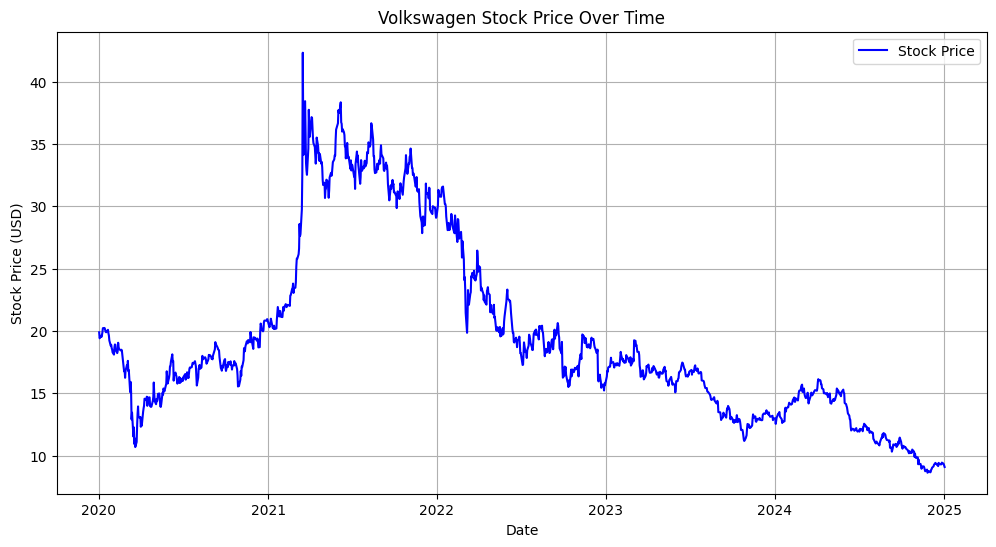

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Stock Price", color="blue")
plt.title("Volkswagen Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

*   Stock price shows upward and downward trends.
*   Patterns suggest seasonality, requiring decomposition.

## **Seasonal Decomposition**

To analyze trend, seasonality, and residuals, we decomposed the stock price time series.

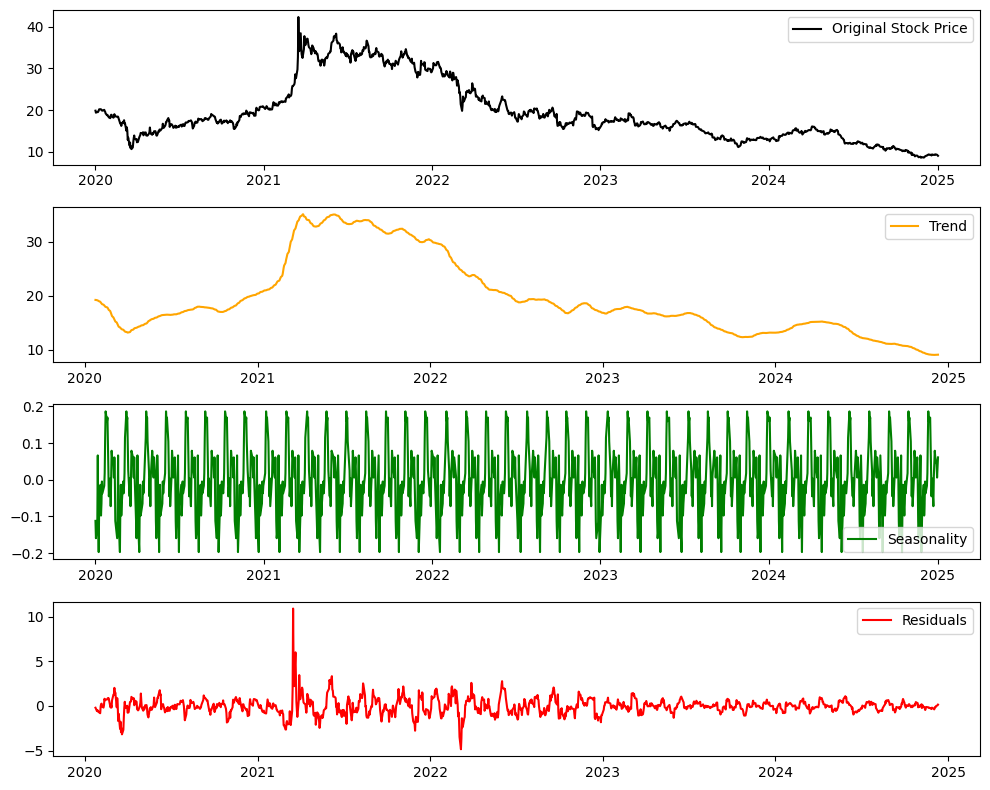

In [ ]:
decomposition = seasonal_decompose(df["Price"], model='additive', period=30)

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df.index, df["Price"], label="Original Stock Price", color="black")
plt.legend()
plt.subplot(412)
plt.plot(df.index, decomposition.trend, label="Trend", color='orange')
plt.legend()
plt.subplot(413)
plt.plot(df.index, decomposition.seasonal, label="Seasonality", color='green')
plt.legend()
plt.subplot(414)
plt.plot(df.index, decomposition.resid, label="Residuals", color='red')
plt.legend()
plt.tight_layout()
plt.show()

**Findings:**

* Stock prices follow a seasonal pattern, validating the use of SARIMA models.
* Residual errors suggest external factors influence stock movement.

### **Moving Averages**
* Smoothing fluctuations with weekly & monthly averages

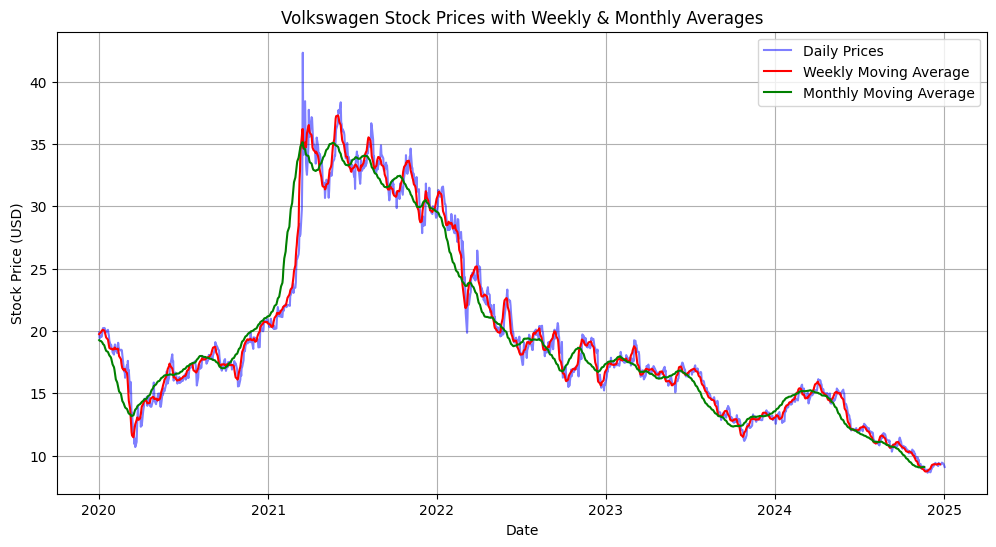

In [ ]:
df["Weekly Avg"] = df["Price"].rolling(window=7).mean()
df["Monthly Avg"] = df["Price"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Daily Prices", alpha=0.5, color="blue")
plt.plot(df.index, df["Weekly Avg"], label="Weekly Moving Average", color="red")
plt.plot(df.index, df["Monthly Avg"], label="Monthly Moving Average", color="green")
plt.title("Volkswagen Stock Prices with Weekly & Monthly Averages")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


### **Principal Component Analysis (PCA)**

* Explained Variance Ratio: [0.998869097, 0.000752903257]
* PCA confirms that most of the variance in stock price data is captured by the first component.

In [ ]:
pca_features = df[['Price', 'Open', 'High', 'Low']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pca_features)

pca = PCA(n_components=2)
pca.fit(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio from PCA:", explained_variance)


Explained Variance Ratio from PCA: [9.98869097e-01 7.52903257e-04]


**Findings:**

* Short-term fluctuations are smoothed by moving averages.
* Helps in understanding long-term stock trends.

### **Model Performance Comparisons**
Evaluated multiple forecasting models, selecting the Hybrid XGBoost + LSTM as the best-performing model.

| Model | RMSE (Lower = Better) | Key Findings |
|--------|------------------|--------------|
| **LSTM Only** | **1.6527** | Captured long-term trends but overestimated prices. |
| **SARIMA** | **1.0026** | Captured seasonal trends but struggled with volatility. |
| **ARIMA** | **Flat predictions** | Unable to model stock fluctuations effectively. |
| **Hybrid LSTM + SARIMA** | **Slight improvement** | Seasonality was handled, but errors remained. |
| **Hybrid LSTM + ARIMA** | **1.2920** | LSTM captured long-term trends, ARIMA corrected residuals. |
| **XGBoost** | **0.1511** | Learned stock price patterns better than LSTM/SARIMA. |
| **Hybrid XGBoost + LSTM (Best)** | **0.1439** | XGBoost captured trends, LSTM fine-tuned residuals for improved accuracy. |


### **Hybrid XGBoost + LSTM Model Implementation**

XGBoost is trained on past price data using lag features to predict stock prices.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

file_path = "/content/Volkswagen_Cleaned_Stock_Data.csv"
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Function to create lag features
def create_lagged_features(data, target_col='Price', lags=30):
    df_lagged = data.copy()
    for i in range(1, lags+1):
        df_lagged[f"Lag_{i}"] = df_lagged[target_col].shift(i)

    df_lagged.dropna(inplace=True)  # Remove NaN values due to shifting
    return df_lagged

# Create dataset with lag features
df_lagged = create_lagged_features(df, target_col='Price', lags=30)

# Split into training (80%) and testing (20%) sets
train_size = int(len(df_lagged) * 0.8)
train, test = df_lagged.iloc[:train_size], df_lagged.iloc[train_size:]

# Define features (X) and target variable (y)
X_train, y_train = train.drop(columns=['Price']), train['Price']
X_test, y_test = test.drop(columns=['Price']), test['Price']

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Make XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test)

# Compute residuals (errors)
residuals = y_test - y_pred_xgb

# Evaluate performance
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

XGBoost RMSE: 0.1511


**Findings:**

XGBoost successfully learned stock price trends.
Residuals indicate errors to be corrected using LSTM.

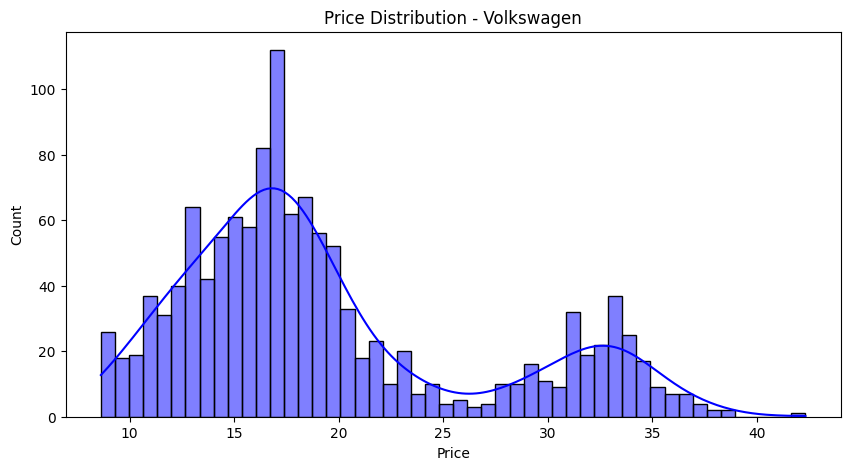

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the price distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["Price"], bins=50, kde=True, color="blue")
plt.title("Price Distribution - Volkswagen")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


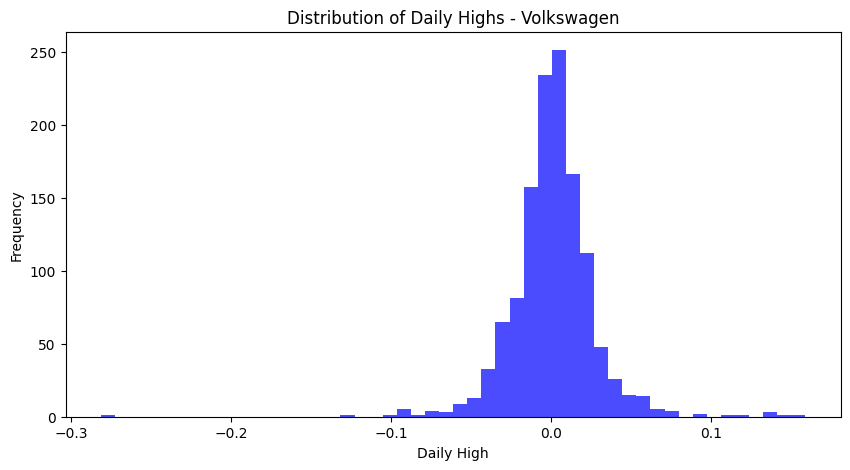

In [ ]:
# Plot the distribution of daily highs
plt.figure(figsize=(10, 5))
plt.hist(df["High"].pct_change().dropna(), bins=50, alpha=0.7, color="blue")
plt.title("Distribution of Daily Highs - Volkswagen")
plt.xlabel("Daily High")
plt.ylabel("Frequency")
plt.show()

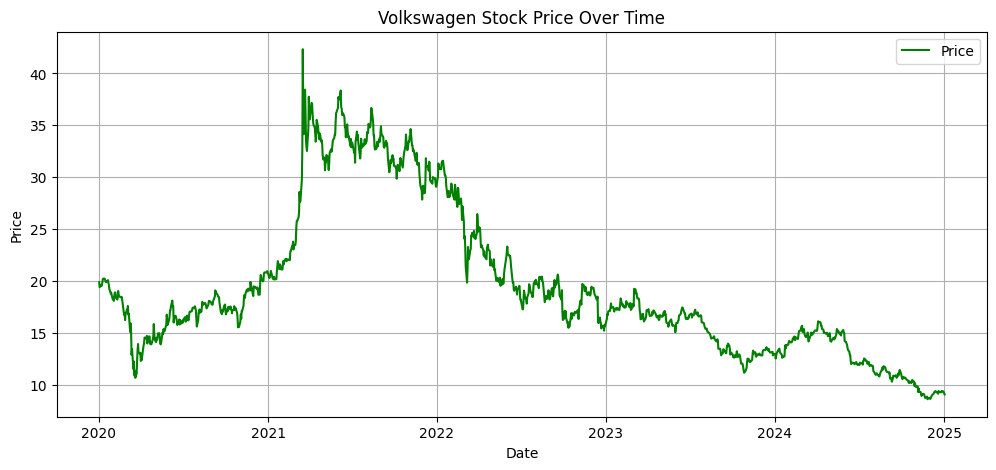

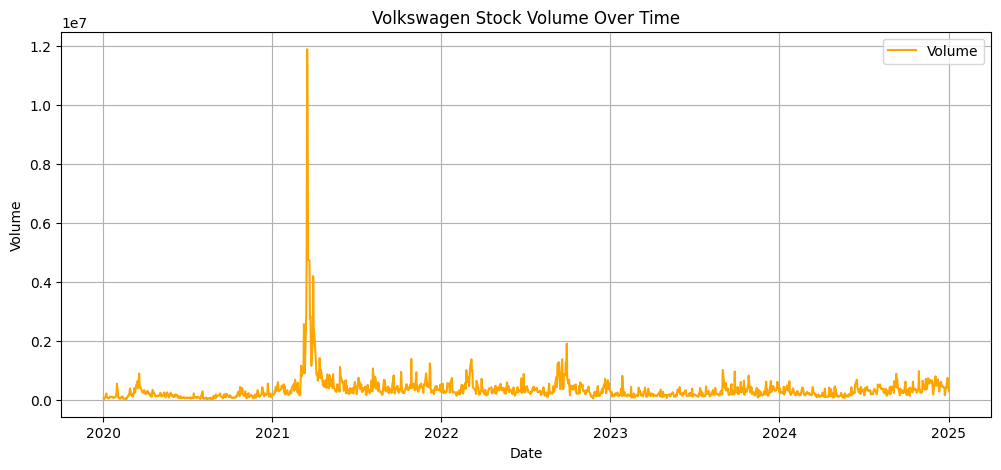

In [ ]:
# Plot stock price over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Price"], label="Price", color="green")
plt.title("Volkswagen Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot volume over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Vol."], label="Volume", color="orange")
plt.title("Volkswagen Stock Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()


Missing Values Per Column:
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


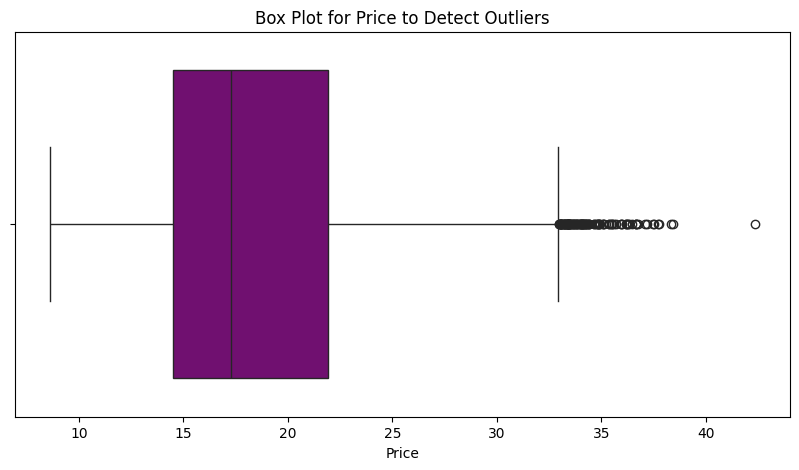

In [ ]:
# Check for missing values
print("Missing Values Per Column:")
print(df.isnull().sum())

# Box plot for outlier detection
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Price"], color="purple")
plt.title("Box Plot for Price to Detect Outliers")
plt.show()
